# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- **This homework must be completed individually.**

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.


Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import these libraries

In [2]:
import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from pandas.core import datetools
%matplotlib inline

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:24: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


In [3]:
""" Some additional imports """
import seaborn as sns
sns.set()

""" Settings for visuals"""
alpha = 0.5

warnings.filterwarnings('ignore')

# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the [Capital Bikeshare program](https://www.capitalbikeshare.com) in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



<div class='exercise'> <b> Question 1 [20pts]  Data pre-processing </b> </div>

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicollinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and **test** your code by producing `practice_y_train` and `practice_X_train`.

**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.



### Solutions 

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

In [4]:
# your code here
bikes_main = pd.read_csv("data/bikes_student.csv",index_col=0).reset_index(drop=True)

bikes_train, bikes_val = train_test_split(bikes_main, 
                                          test_size = .2, 
                                          stratify=bikes_main['month'], 
                                          random_state=90)

bikes_train.head()

dteday  hour  year  holiday  workingday  temp   atemp   hum  \
540  2012-10-23    23     1        0           1  0.54  0.5152  0.73   
367  2011-06-29    11     0        0           1  0.76  0.6667  0.35   
869  2012-08-24     2     1        0           1  0.66  0.6212  0.69   
216  2012-10-31     5     1        0           1  0.30  0.3030  0.81   
238  2012-08-24    21     1        0           1  0.70  0.6515  0.61   

     windspeed  casual  ...    Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  Snow  \
540     0.1045       9  ...      0    1    0    0    0    0       0     0   
367     0.2239      53  ...      0    0    1    0    0    0       0     0   
869     0.0000       1  ...      0    0    0    0    1    0       0     0   
216     0.1343       0  ...      0    0    1    0    0    0       1     0   
238     0.1642      58  ...      0    0    0    0    1    0       1     0   

     Storm  month  
540      0     10  
367      0      6  
869      0      8  
216      0     10  
238      0      8  

[5 rows x 36 columns]

**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicolinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_y_train` and `practice_X_train`


In [5]:
# your code here

# your code here
def split_columns(df, target_col, drop_columns):
    """
    :param: df: Your DataFrame
    :param: target_col: The name of the response variable
    :param: drop_columns: List containing the column names you want to drop
    :return: (X_train, y_train)
    """
    # Get the response variable
    y_train = df[[target_col]]

    # Drop the required columns
    X_train = df.drop(drop_columns,axis=1)
    
    return X_train, y_train


target_column = 'counts'

drop_columns = ['counts','registered','casual',
                'workingday','month','dteday']

practice_X_train, practice_y_train = split_columns(bikes_train, 
                                                   target_column, 
                                                   drop_columns)

print(practice_X_train.columns.values)
practice_X_train.head()

['hour' 'year' 'holiday' 'temp' 'atemp' 'hum' 'windspeed' 'Feb' 'Mar'
 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sept' 'Oct' 'Nov' 'Dec' 'spring' 'summer'
 'fall' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' 'Sat' 'Cloudy' 'Snow' 'Storm']


hour  year  holiday  temp   atemp   hum  windspeed  Feb  Mar  Apr  ...    \
540    23     1        0  0.54  0.5152  0.73     0.1045    0    0    0  ...     
367    11     0        0  0.76  0.6667  0.35     0.2239    0    0    0  ...     
869     2     1        0  0.66  0.6212  0.69     0.0000    0    0    0  ...     
216     5     1        0  0.30  0.3030  0.81     0.1343    0    0    0  ...     
238    21     1        0  0.70  0.6515  0.61     0.1642    0    0    0  ...     

     fall  Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  Snow  Storm  
540     1    0    1    0    0    0    0       0     0      0  
367     0    0    0    1    0    0    0       0     0      0  
869     0    0    0    0    0    1    0       0     0      0  
216     1    0    0    1    0    0    0       1     0      0  
238     0    0    0    0    0    1    0       1     0      0  

[5 rows x 30 columns]

**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


In [6]:
# your code here

# your code here

binary_columns = ['holiday','Feb', 'Mar', 'Apr',
                  'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 
                  'Dec', 'spring', 'summer', 'fall', 'Mon', 'Tue', 
                  'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']

def scale_datasets(train_data, test_data, cols_to_scale):
    """
    This function will be used to standardize columns in your datasets. It
    also allows you to pass in a test dataset, which will be standardized
    using the stats from the training data. 
    
    :param: train: The training dataset
    :param: test: The test dataset, which will be standardized using stats 
                  from the training data. 
    :param: cols_to_scale: List containing the column names to be standardized
    :return: (DataFrame, DataFrame) Standardized test and training DataFrames
    """
    
    train = train_data.copy()
    test = test_data.copy()
    
    # Fit the scaler on the training data
    scaler = StandardScaler().fit(train[cols_to_scale])

    # Scale both the test and training data. 
    train[cols_to_scale] = scaler.transform(train[cols_to_scale])
    test[cols_to_scale] = scaler.transform(test[cols_to_scale])
    
    return train, test

# Get the columns that we actually want to scale
to_scale = practice_X_train.columns.difference(binary_columns)

practice_X_train_scaled, _ = scale_datasets(practice_X_train, 
                                            practice_X_train, 
                                            to_scale)

practice_X_train_scaled.describe()

hour          year      holiday          temp         atemp  \
count  1.000000e+03  1.000000e+03  1000.000000  1.000000e+03  1.000000e+03   
mean  -1.243450e-16 -7.105427e-17     0.027000  4.263256e-17 -1.083578e-16   
std    1.000500e+00  1.000500e+00     0.162164  1.000500e+00  1.000500e+00   
min   -1.646163e+00 -1.018165e+00     0.000000 -2.347976e+00 -2.402605e+00   
25%   -9.189949e-01 -1.018165e+00     0.000000 -7.922693e-01 -8.121270e-01   
50%   -4.639332e-02  9.821591e-01     0.000000  3.744066e-02  7.147176e-02   
75%    8.262083e-01  9.821591e-01     0.000000  8.671507e-01  8.670022e-01   
max    1.698810e+00  9.821591e-01     1.000000  2.319143e+00  2.546131e+00   

                hum     windspeed          Feb          Mar          Apr  \
count  1.000000e+03  1.000000e+03  1000.000000  1000.000000  1000.000000   
mean   1.101341e-16  9.148238e-17     0.078000     0.085000     0.082000   
std    1.000500e+00  1.000500e+00     0.268306     0.279021     0.274502   
min   -3.397602e+00 -1.554205e+00     0.000000     0.000000     0.000000   
25%   -7.421467e-01 -7.231056e-01     0.000000     0.000000     0.000000   
50%    5.448995e-02 -1.130295e-02     0.000000     0.000000     0.000000   
75%    8.511266e-01  4.634972e-01     0.000000     0.000000     0.000000   
max    1.913309e+00  5.211499e+00     1.000000     1.000000     1.000000   

        ...           fall          Mon          Tue          Wed  \
count   ...    1000.000000  1000.000000  1000.000000  1000.000000   
mean    ...       0.248000     0.143000     0.148000     0.162000   
std     ...       0.432068     0.350248     0.355278     0.368635   
min     ...       0.000000     0.000000     0.000000     0.000000   
25%     ...       0.000000     0.000000     0.000000     0.000000   
50%     ...       0.000000     0.000000     0.000000     0.000000   
75%     ...       0.000000     0.000000     0.000000     0.000000   
max     ...       1.000000     1.000000     1.000000     1.000000   

               Thu         Fri         Sat       Cloudy         Snow   Storm  
count  1000.000000  1000.00000  1000.00000  1000.000000  1000.000000  1000.0  
mean      0.128000     0.12700     0.15000     0.280000     0.082000     0.0  
std       0.334257     0.33314     0.35725     0.449224     0.274502     0.0  
min       0.000000     0.00000     0.00000     0.000000     0.000000     0.0  
25%       0.000000     0.00000     0.00000     0.000000     0.000000     0.0  
50%       0.000000     0.00000     0.00000     0.000000     0.000000     0.0  
75%       0.000000     0.00000     0.00000     1.000000     0.000000     0.0  
max       1.000000     1.00000     1.00000     1.000000     1.000000     0.0  

[8 rows x 30 columns]

**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with apropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with qudratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

In [7]:
# your code here

# your code here

def add_poly_features(dataset, degree, columns):
    """
    :param dataset: Your data
    :param degree: Max degree
    :return: Augmented DataFrame
    """
    # Make a copy of the dataset
    poly_dataset = dataset.copy()
    
    # Use this to generate the polynomial terms
    maker = PolynomialFeatures(degree, include_bias=False)
        
    # Loop over each column we want to generate polynomials terms for
    for cur_col in columns:
        # Create the polynomial terms
        poly_values = maker.fit_transform(poly_dataset[[cur_col]])
        
        # Get the new column names
        poly_names = maker.get_feature_names([cur_col])
        
        # Add the new columns back to the original dataframe copy
        to_add = pd.DataFrame(poly_values[:,1:], 
                              index=poly_dataset.index, 
                              columns=poly_names[1:])
        
        poly_dataset = pd.concat([poly_dataset, to_add], axis=1)

    return poly_dataset

poly_columns = ['temp', 'atemp', 'hum','windspeed', 'hour']

practice_X_train_poly = add_poly_features(practice_X_train_scaled,3, poly_columns)

print(practice_X_train_poly.columns.values)
practice_X_train_poly.head()

['hour' 'year' 'holiday' 'temp' 'atemp' 'hum' 'windspeed' 'Feb' 'Mar'
 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sept' 'Oct' 'Nov' 'Dec' 'spring' 'summer'
 'fall' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' 'Sat' 'Cloudy' 'Snow' 'Storm'
 'temp^2' 'temp^3' 'atemp^2' 'atemp^3' 'hum^2' 'hum^3' 'windspeed^2'
 'windspeed^3' 'hour^2' 'hour^3']


hour      year  holiday      temp     atemp       hum  windspeed  \
540  1.698810  0.982159        0  0.244868  0.248775  0.479363  -0.723106   
367 -0.046393 -1.018165        0  1.385719  1.132373 -1.538783   0.226495   
869 -1.355296  0.982159        0  0.867151  0.867002  0.266926  -1.554205   
216 -0.918995  0.982159        0 -0.999697 -0.988847  0.904236  -0.486103   
238  1.407943  0.982159        0  1.074578  1.043722 -0.157946  -0.248305   

     Feb  Mar  Apr    ...       temp^2    temp^3   atemp^2   atemp^3  \
540    0    0    0    ...     0.059960  0.014682  0.061889  0.015396   
367    0    0    0    ...     1.920218  2.660884  1.282270  1.452008   
869    0    0    0    ...     0.751950  0.652054  0.751693  0.651719   
216    0    0    0    ...     0.999394 -0.999091  0.977818 -0.966912   
238    0    0    0    ...     1.154718  1.240835  1.089356  1.136984   

        hum^2     hum^3  windspeed^2  windspeed^3    hour^2    hour^3  
540  0.229789  0.110152     0.522882    -0.378099  2.885955  4.902689  
367  2.367854 -3.643615     0.051300     0.011619  0.002152 -0.000100  
869  0.071250  0.019018     2.415552    -3.754263  1.836827 -2.489443  
216  0.817642  0.739341     0.236296    -0.114864  0.844552 -0.776139  
238  0.024947 -0.003940     0.061656    -0.015309  1.982303  2.790969  

[5 rows x 40 columns]

**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**


In [8]:
# your code here

interact_left = ['temp','atemp','hum','windspeed']
interact_right = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept',
                  'Oct', 'Nov', 'Dec','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

def build_interaction(df, interact_left, interact_right):
    """
    :param df: Your data
    :param interact_left: The first set of columns you want to use in interactions
    :param interact_right: The set of columns you want to generate interactions terms
                           with in interact_left
    """
    result_df =  df.copy()
    
    # Loop over all the left interactions
    for left_name in interact_left:
        left_column = df[left_name]
        
        # For each left interaction column, create an interaction
        # with each column in the right interaction list.
        for right_name in interact_right:
            right_column = df[right_name]
            combined_name = "{}*{}".format(left_name, right_name)
            result_df[combined_name] = left_column*right_column

    return result_df


practice_train_done = build_interaction(practice_X_train_poly, 
                                        interact_left, interact_right)

print(practice_train_done.columns.values)
practice_train_done.head()

['hour' 'year' 'holiday' 'temp' 'atemp' 'hum' 'windspeed' 'Feb' 'Mar'
 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sept' 'Oct' 'Nov' 'Dec' 'spring' 'summer'
 'fall' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' 'Sat' 'Cloudy' 'Snow' 'Storm'
 'temp^2' 'temp^3' 'atemp^2' 'atemp^3' 'hum^2' 'hum^3' 'windspeed^2'
 'windspeed^3' 'hour^2' 'hour^3' 'temp*Feb' 'temp*Mar' 'temp*Apr'
 'temp*May' 'temp*Jun' 'temp*Jul' 'temp*Aug' 'temp*Sept' 'temp*Oct'
 'temp*Nov' 'temp*Dec' 'temp*Mon' 'temp*Tue' 'temp*Wed' 'temp*Thu'
 'temp*Fri' 'temp*Sat' 'atemp*Feb' 'atemp*Mar' 'atemp*Apr' 'atemp*May'
 'atemp*Jun' 'atemp*Jul' 'atemp*Aug' 'atemp*Sept' 'atemp*Oct' 'atemp*Nov'
 'atemp*Dec' 'atemp*Mon' 'atemp*Tue' 'atemp*Wed' 'atemp*Thu' 'atemp*Fri'
 'atemp*Sat' 'hum*Feb' 'hum*Mar' 'hum*Apr' 'hum*May' 'hum*Jun' 'hum*Jul'
 'hum*Aug' 'hum*Sept' 'hum*Oct' 'hum*Nov' 'hum*Dec' 'hum*Mon' 'hum*Tue'
 'hum*Wed' 'hum*Thu' 'hum*Fri' 'hum*Sat' 'windspeed*Feb' 'windspeed*Mar'
 'windspeed*Apr' 'windspeed*May' 'windspeed*Jun' 'windspeed*Jul'
 'windspeed*Aug' 

hour      year  holiday      temp     atemp       hum  windspeed  \
540  1.698810  0.982159        0  0.244868  0.248775  0.479363  -0.723106   
367 -0.046393 -1.018165        0  1.385719  1.132373 -1.538783   0.226495   
869 -1.355296  0.982159        0  0.867151  0.867002  0.266926  -1.554205   
216 -0.918995  0.982159        0 -0.999697 -0.988847  0.904236  -0.486103   
238  1.407943  0.982159        0  1.074578  1.043722 -0.157946  -0.248305   

     Feb  Mar  Apr      ...        windspeed*Sept  windspeed*Oct  \
540    0    0    0      ...                  -0.0      -0.723106   
367    0    0    0      ...                   0.0       0.000000   
869    0    0    0      ...                  -0.0      -0.000000   
216    0    0    0      ...                  -0.0      -0.486103   
238    0    0    0      ...                  -0.0      -0.000000   

     windspeed*Nov  windspeed*Dec  windspeed*Mon  windspeed*Tue  \
540           -0.0           -0.0           -0.0      -0.723106   
367            0.0            0.0            0.0       0.000000   
869           -0.0           -0.0           -0.0      -0.000000   
216           -0.0           -0.0           -0.0      -0.000000   
238           -0.0           -0.0           -0.0      -0.000000   

     windspeed*Wed  windspeed*Thu  windspeed*Fri  windspeed*Sat  
540      -0.000000           -0.0      -0.000000           -0.0  
367       0.226495            0.0       0.000000            0.0  
869      -0.000000           -0.0      -1.554205           -0.0  
216      -0.486103           -0.0      -0.000000           -0.0  
238      -0.000000           -0.0      -0.248305           -0.0  

[5 rows x 108 columns]

**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [9]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'atemp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'registered', 'casual', 'workingday', 'month', 'dteday']):
    # add code here 
    return x_train,y_train, x_val,y_val


In [10]:
# your code here
# your code here

def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'atemp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'registered', 'casual', 
                                 'workingday', 'month', 'dteday']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    # Split and drop what we don't need
    x_train, y_train = split_columns(train_df, 
                                     target_col, 
                                     drop_columns=bad_columns)
    x_val, y_val = split_columns(val_df, 
                                 target_col, 
                                 drop_columns=bad_columns)
    
    # Scale the Columns
    to_scale = x_train.columns.difference(binary_columns)
    x_train, x_val = scale_datasets(x_train, x_val, to_scale)

    # Add Polynomial Features
    x_train = add_poly_features(x_train,  degree, columns=columns_forpoly)
    x_val = add_poly_features(x_val, degree, columns=columns_forpoly)

    # Add the Interaction Terms
    x_train = build_interaction(x_train, interact_left, interact_right)
    x_val = build_interaction(x_val, interact_left, interact_right)

    # Scale the Columns
    #to_scale = x_train.columns.difference(binary_columns)
    #x_train, x_val = scale_datasets(x_train, x_val, to_scale)

    
    return x_train,y_train, x_val,y_val

X_train, y_train, X_val, y_val = get_design_mats(bikes_train, bikes_val, degree=3)

X_train.describe()

hour          year      holiday          temp         atemp  \
count  1.000000e+03  1.000000e+03  1000.000000  1.000000e+03  1.000000e+03   
mean  -1.243450e-16 -7.105427e-17     0.027000  4.263256e-17 -1.083578e-16   
std    1.000500e+00  1.000500e+00     0.162164  1.000500e+00  1.000500e+00   
min   -1.646163e+00 -1.018165e+00     0.000000 -2.347976e+00 -2.402605e+00   
25%   -9.189949e-01 -1.018165e+00     0.000000 -7.922693e-01 -8.121270e-01   
50%   -4.639332e-02  9.821591e-01     0.000000  3.744066e-02  7.147176e-02   
75%    8.262083e-01  9.821591e-01     0.000000  8.671507e-01  8.670022e-01   
max    1.698810e+00  9.821591e-01     1.000000  2.319143e+00  2.546131e+00   

                hum     windspeed          Feb          Mar          Apr  \
count  1.000000e+03  1.000000e+03  1000.000000  1000.000000  1000.000000   
mean   1.101341e-16  9.148238e-17     0.078000     0.085000     0.082000   
std    1.000500e+00  1.000500e+00     0.268306     0.279021     0.274502   
min   -3.397602e+00 -1.554205e+00     0.000000     0.000000     0.000000   
25%   -7.421467e-01 -7.231056e-01     0.000000     0.000000     0.000000   
50%    5.448995e-02 -1.130295e-02     0.000000     0.000000     0.000000   
75%    8.511266e-01  4.634972e-01     0.000000     0.000000     0.000000   
max    1.913309e+00  5.211499e+00     1.000000     1.000000     1.000000   

           ...        windspeed*Sept  windspeed*Oct  windspeed*Nov  \
count      ...           1000.000000    1000.000000    1000.000000   
mean       ...             -0.014081      -0.014803       0.001709   
std        ...              0.242928       0.281089       0.288773   
min        ...             -1.554205      -1.554205      -1.554205   
25%        ...              0.000000       0.000000       0.000000   
50%        ...             -0.000000       0.000000      -0.000000   
75%        ...              0.000000       0.000000       0.000000   
max        ...              2.600496       2.600496       2.837498   

       windspeed*Dec  windspeed*Mon  windspeed*Tue  windspeed*Wed  \
count    1000.000000    1000.000000    1000.000000    1000.000000   
mean       -0.017209      -0.013921      -0.013266       0.004386   
std         0.310498       0.370430       0.346023       0.403203   
min        -1.554205      -1.554205      -1.554205      -1.554205   
25%         0.000000       0.000000       0.000000       0.000000   
50%        -0.000000       0.000000      -0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         3.312298       4.143398       2.600496       2.600496   

       windspeed*Thu  windspeed*Fri  windspeed*Sat  
count    1000.000000    1000.000000    1000.000000  
mean       -0.011268       0.001801       0.017336  
std         0.312060       0.376432       0.428265  
min        -1.554205      -1.554205      -1.554205  
25%         0.000000       0.000000      -0.000000  
50%         0.000000      -0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max         3.668597       3.312298       3.668597  

[8 rows x 108 columns]

<div class='exercise'> <b> Question 2 [20pts]: Regularization via Ridge </b></div>

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**2.4** Find the best-scoring degree and regularization combination.

**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

### Solutions 

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

In [11]:
# your code here
# your code here

degrees = range(1,9)
train_r2 = np.zeros(len(degrees))
test_r2 = np.zeros(len(degrees))

for cur_degree in degrees:

    X_train, y_train, X_test, y_test = get_design_mats(bikes_train, 
                                                       bikes_val,  
                                                       cur_degree)

    fitted_model = LinearRegression().fit(X_train, y_train)

    train_r2[cur_degree-1] = fitted_model.score(X_train, y_train)
    test_r2[cur_degree-1] = fitted_model.score(X_test, y_test)

pd.DataFrame({'train_score': train_r2, 'test_score': test_r2},
             index=degrees)

train_score  test_score
1     0.484997    0.333359
2     0.577436    0.450571
3     0.626488    0.461470
4     0.632332    0.445117
5     0.647222    0.477027
6     0.668668    0.478536
7     0.697748    0.537901
8     0.706927    0.556701

**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?**

*your answer here*

*From 2.1 we see that train $R^2$ keeps on increasing as we increase the degree i.e model is overfitting to training data.*

*Although validation $R^2$ is high for degree 7 and 8, it is unlikely that real data reflects that. Also it would make model less interpretable.  Based on above, degree 2 or degree 3 model seems like a good choice.*

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 


In [12]:
# your code here
# your code here

#alphas = np.array([.0001, .0005, .001, .005, .01, .05, .1,.5, 1, 5, 10, 50, 100])
alphas = np.array([.01, .05, .1, .5, 1, 5, 10, 50, 100])

# Arrays to hold our scores
train_r2s = np.zeros((len(degrees),len(alphas)))
val_r2s = np.zeros((len(degrees),len(alphas)))

# Loop over each degree
for cur_row, cur_degree in enumerate(degrees):

    # Get the  design matrix
    X_train, y_train, X_test, y_test = get_design_mats(bikes_train, 
                                                         bikes_val, 
                                                         cur_degree)

    # Loop over each alpha value
    for cur_col, cur_alpha in enumerate(alphas):

        # Fit and Score
        fitted_model = Ridge(alpha=cur_alpha).fit(X_train, y_train)
        
        # Get predictions on the test set
        y_test_hat = fitted_model.predict(X_test)

        # Store results
        train_r2s[cur_row,cur_col] = fitted_model.score(X_train, y_train)
        val_r2s[cur_row,cur_col] = r2_score(y_test, y_test_hat)
                    
print("Training Set Performance")
display(pd.DataFrame(train_r2s, index = degrees, columns = alphas))

print("Validation Set Performance")
pd.DataFrame(val_r2s, index = degrees, columns = alphas)

Training Set Performance


0.01      0.05      0.10      0.50      1.00      5.00      10.00   \
1  0.484979  0.484820  0.484557  0.482444  0.480700  0.475369  0.471987   
2  0.577396  0.577126  0.576721  0.573921  0.571844  0.565708  0.561962   
3  0.626462  0.626235  0.625836  0.622999  0.621028  0.615365  0.611173   
4  0.632325  0.632201  0.631947  0.629976  0.628493  0.622997  0.617962   
5  0.647211  0.647070  0.646804  0.644872  0.643461  0.638529  0.634383   
6  0.668658  0.668515  0.668265  0.666561  0.665167  0.658677  0.653198   
7  0.697729  0.697494  0.697102  0.693984  0.690452  0.672604  0.661439   
8  0.706900  0.706537  0.705886  0.700066  0.694008  0.671939  0.661135   

     50.00     100.00  
1  0.455275  0.441231  
2  0.545581  0.532917  
3  0.584376  0.559400  
4  0.587829  0.562649  
5  0.612143  0.593816  
6  0.627980  0.607275  
7  0.626304  0.604670  
8  0.630047  0.611475

Validation Set Performance


0.01      0.05      0.10      0.50      1.00      5.00      10.00   \
1  0.334079  0.336303  0.338252  0.344601  0.347245  0.350852  0.350720   
2  0.451156  0.452777  0.454184  0.458863  0.460860  0.462742  0.461501   
3  0.462133  0.464616  0.466878  0.474055  0.477064  0.482930  0.484346   
4  0.445810  0.448139  0.450257  0.457269  0.460419  0.467707  0.470200   
5  0.477541  0.479419  0.481121  0.486543  0.488813  0.493436  0.494610   
6  0.479001  0.480442  0.481841  0.487837  0.491471  0.499539  0.501450   
7  0.538235  0.538780  0.539033  0.537512  0.534090  0.518093  0.511204   
8  0.556880  0.556861  0.556306  0.548498  0.539885  0.514831  0.508011   

     50.00     100.00  
1  0.345421  0.340400  
2  0.453643  0.448234  
3  0.477066  0.464374  
4  0.466792  0.458405  
5  0.491686  0.487166  
6  0.500695  0.496005  
7  0.498667  0.492277  
8  0.500281  0.497137

**2.4** Find the best-scoring degree and regularization combination.

In [13]:
# your code here

# Find out best test score
best_score = np.max(val_r2s)
best_degree_ind = np.argmax(np.max(val_r2s, axis=1))
best_alpha_ind = np.argmax(np.max(val_r2s, axis=0))
best_degree = degrees[best_degree_ind]
best_alpha = alphas[best_alpha_ind]

print("The best model has degree {} and Lambda={}.".format(best_degree, 
                                                           best_alpha))
                                                                      
print("The best model has R2={}".format(val_r2s[best_degree_ind, best_alpha_ind]))

# Fit our optimal model
x_train, y_train, x_score, y_score = get_design_mats(bikes_train, 
                                                     bikes_val, 
                                                     best_degree)

best_model = Ridge(alpha=best_alpha).fit(x_train,y_train)
best_model

The best model has degree 8 and Lambda=0.01.
The best model has R2=0.5568797750208245


Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset `data/bikes_test.csv`, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

In [14]:
# your code here
bikes_test = pd.read_csv("data/bikes_test.csv", index_col=0).reset_index(drop=True)

x_train5, y_train5, x_test5, y_test5 = get_design_mats(bikes_train, 
                                                       bikes_test, 
                                                       best_degree)

r2_test = best_model.score(x_test5,y_test5)
r2_test

0.5668964072050593

**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

*your answer here*

Our model's test score is 0.566896 where as validation score is 0.5568798.  

Ideally we would expect this to be other way around i.e. higher validation score and lower test score. The results seem counter intutive, I suspect this to be data problem or we need better cross validation. 

<div class='exercise'><b> Question 3 [20pts]: Comparing Ridge, Lasso, and OLS </b> </div>

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Solutions

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

In [15]:
#your code here
#your code here
x_train31, y_train31, x_val31, y_val31 = get_design_mats(bikes_main, bikes_val, 1)

fitted_OLS = LinearRegression().fit(x_train31,y_train31)

alphas = (.1,.5,1,5,10,50,100)

fitted_ridge = RidgeCV(alphas=alphas ).fit(x_train31, y_train31)
fitted_lasso = LassoCV(alphas=alphas, max_iter=100000).fit(x_train31, np.ravel(y_train31))


**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

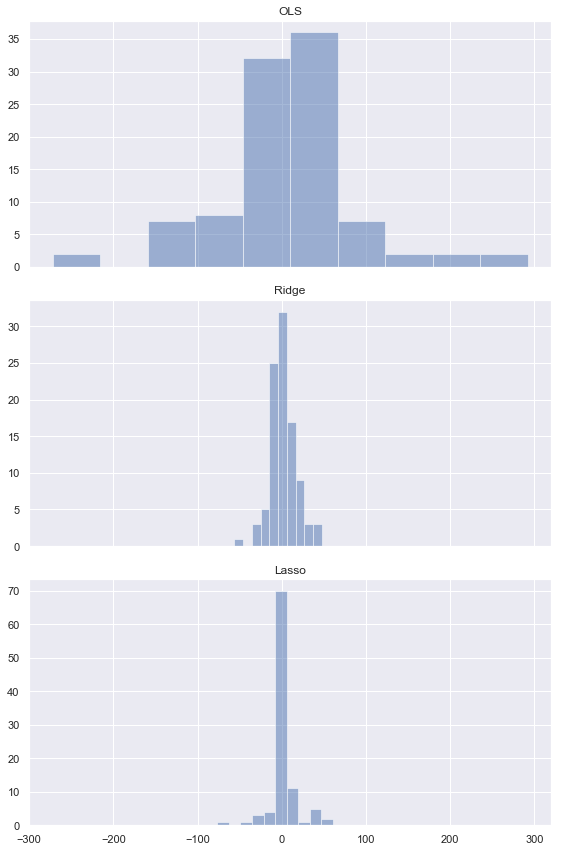

In [16]:
# your code here
# your code here
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 12))

axs[0].hist(fitted_OLS.coef_[0], alpha=alpha)
axs[0].set_title("OLS")

axs[1].hist(fitted_ridge.coef_[0], alpha=alpha)
axs[1].set_title("Ridge")

axs[2].hist(fitted_lasso.coef_, alpha=alpha)
axs[2].set_title("Lasso")
plt.tight_layout()

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

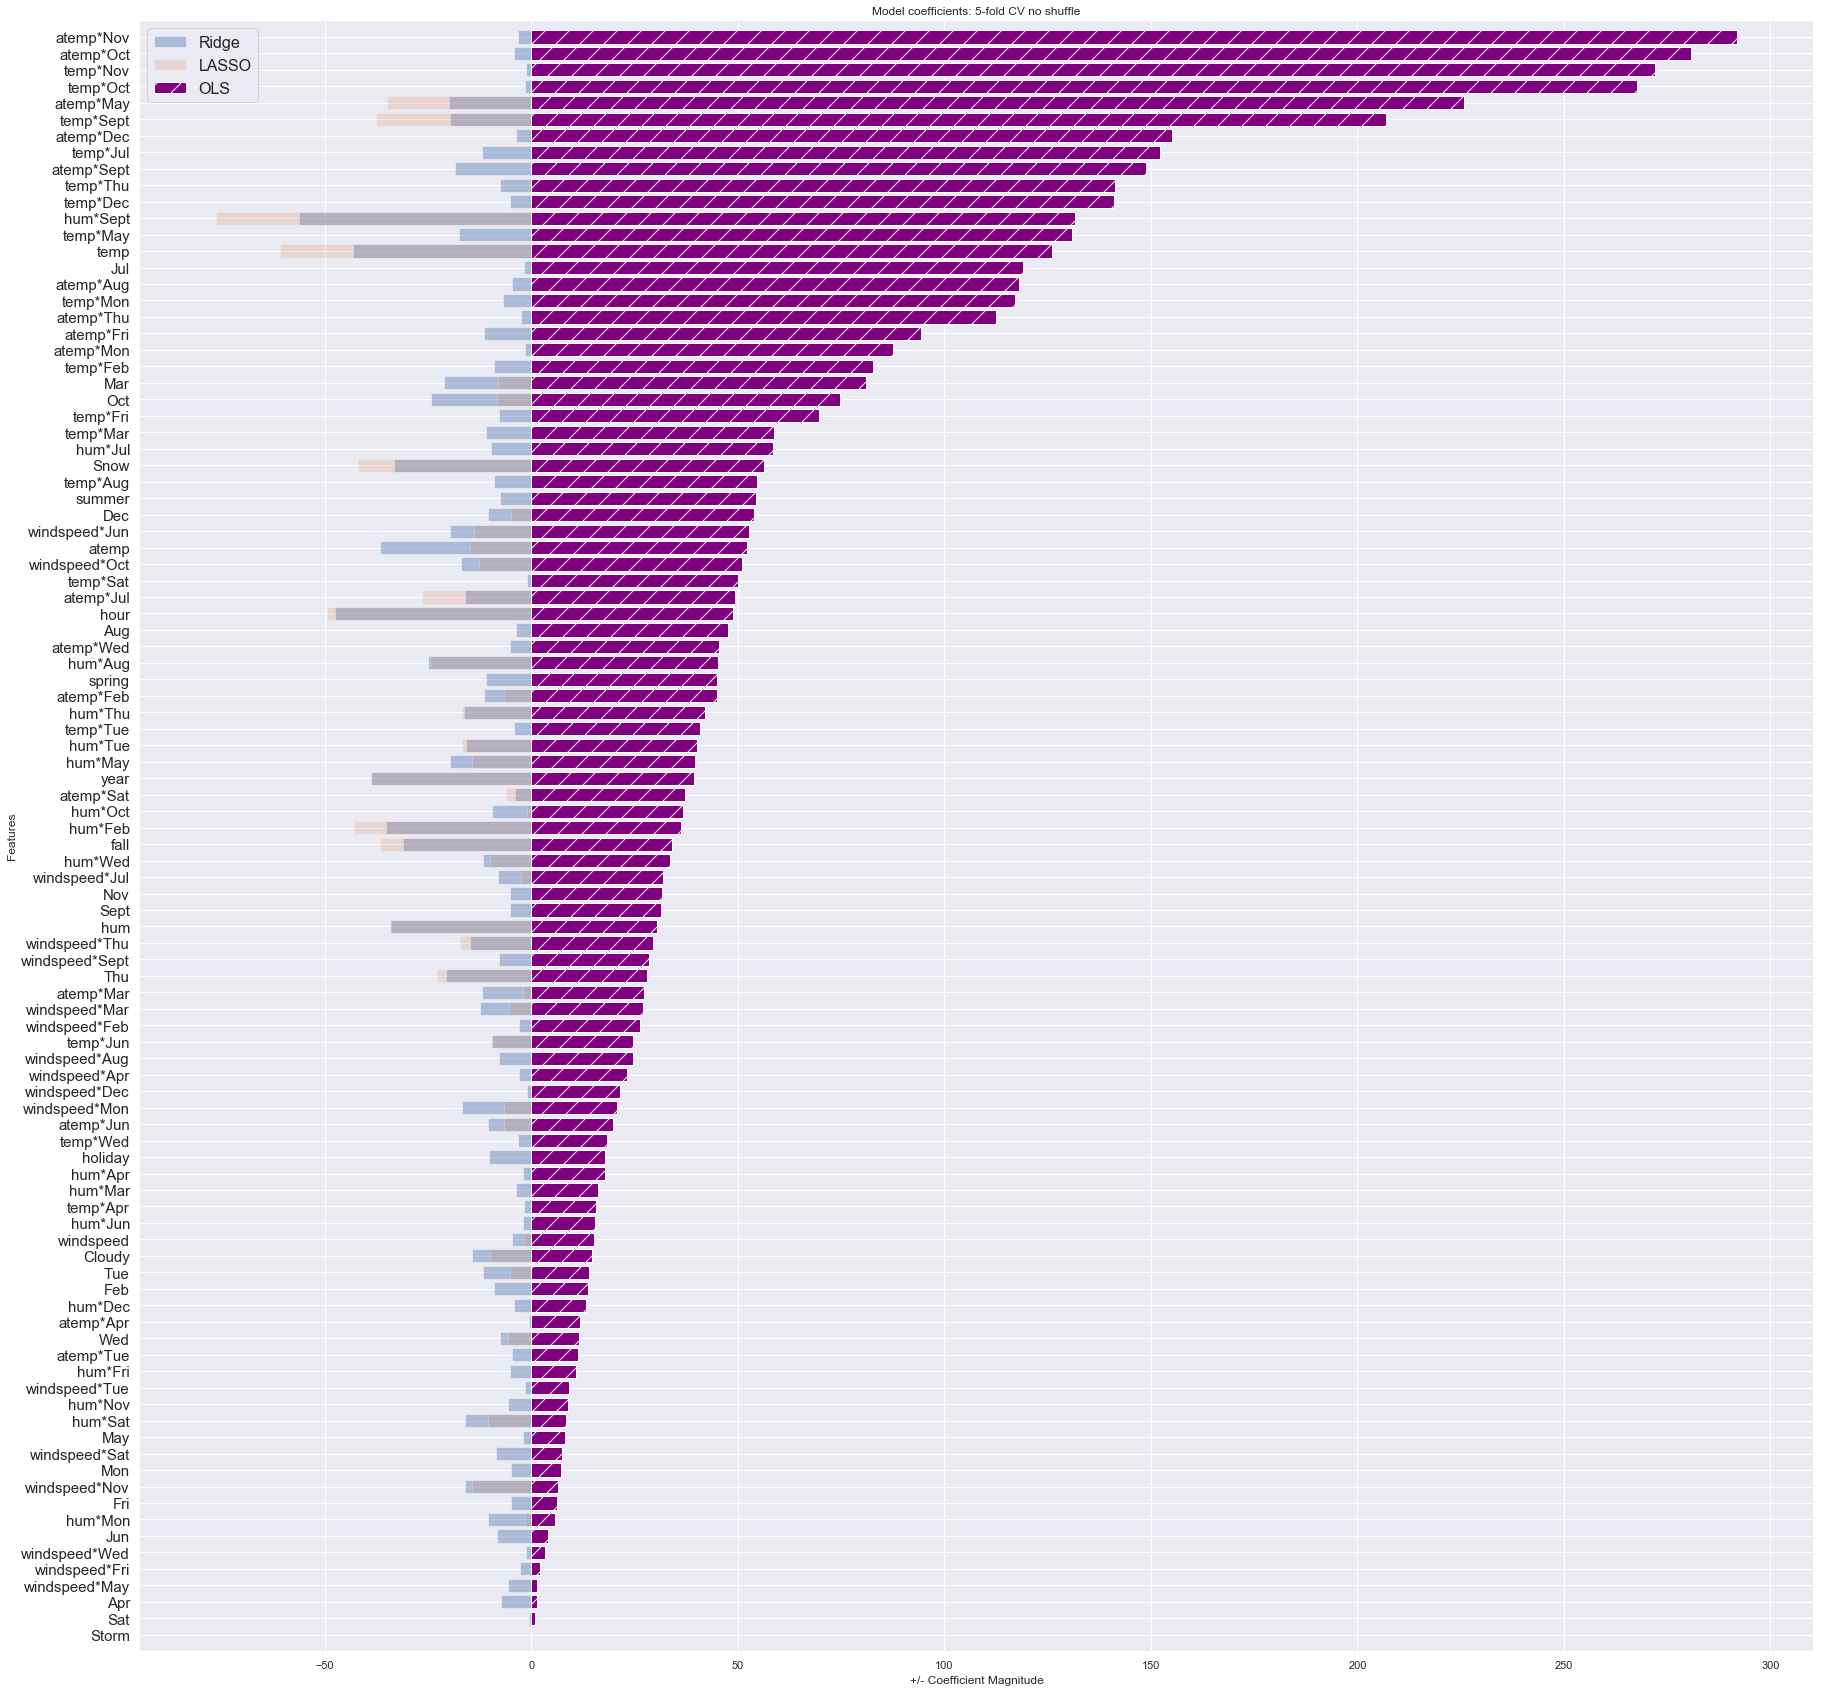

In [17]:
# your code here
feature_names = x_train31.columns.values

Ridge_coefficients = fitted_ridge.coef_
Lasso_coefficients = fitted_lasso.coef_
OLS_coefficients = fitted_OLS.coef_

si= np.argsort(np.abs(fitted_OLS.coef_))
feature_names = x_train31.columns.values[si][0]
n_coeffs = len(feature_names)

plt.figure(figsize=(30,30))
plt.barh(np.arange(n_coeffs), 
         -np.abs(Ridge_coefficients)[0][si][0], 
         alpha=0.4, label='Ridge')

plt.barh(np.arange(n_coeffs), 
         -np.abs(Lasso_coefficients)[si][0], 
         alpha=0.2, label='LASSO')
plt.barh(np.arange(n_coeffs), 
         np.abs(OLS_coefficients)[0][si][0], 
         color='purple', hatch='/', label='OLS')

plt.yticks(range(n_coeffs), feature_names, rotation=0, fontsize=15)
plt.ylim(-1,n_coeffs)
#plt.xlim(-100,300)

plt.legend(fontsize=16)

plt.title("Model coefficients: 5-fold CV no shuffle")
plt.ylabel("Features")
plt.xlabel("+/- Coefficient Magnitude");

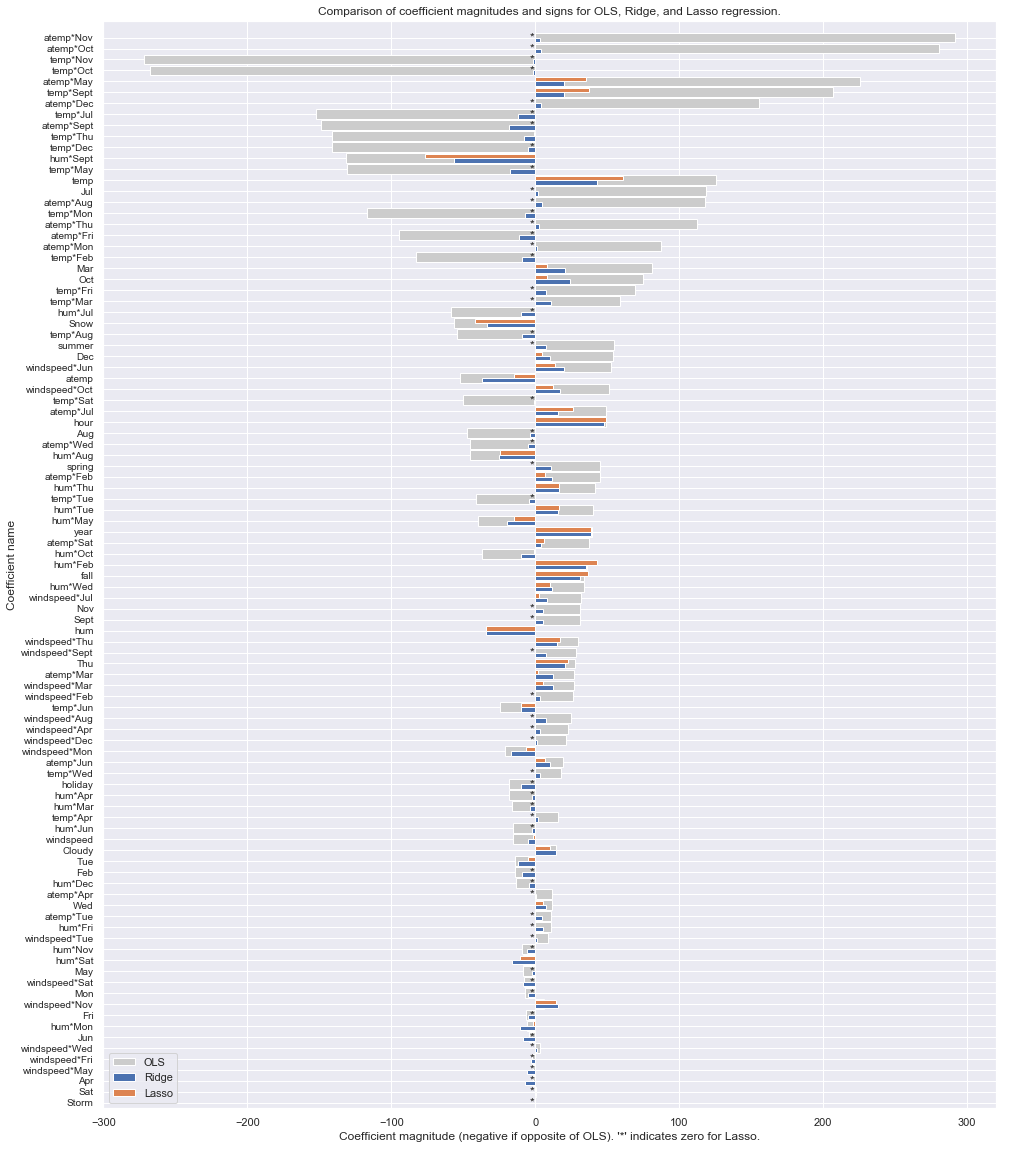

In [18]:
# your code here
feature_names = x_train31.columns.values
n_coeffs = len(feature_names)

coef_labels = x_train31.columns
coef_ticks = np.arange(len(coef_labels))
label_order = np.argsort(np.abs(fitted_OLS.coef_))

fig, ax = plt.subplots(1, 1, figsize=(16, 20))
signs = np.sign(fitted_OLS.coef_[0][label_order])

ax.barh(coef_ticks, (signs * np.abs(fitted_OLS.coef_)[0][label_order])[0] , height=.9, color='#cccccc', label='OLS')
ax.barh(coef_ticks-.2, (signs * np.abs(fitted_ridge.coef_)[0][label_order])[0], alpha=1, height=.4, label='Ridge')
ax.barh(coef_ticks+.2, (signs * np.abs(fitted_lasso.coef_)[label_order])[0], alpha=1, height=.4, label="Lasso")

plt.yticks(coef_ticks, coef_labels[label_order][0], rotation=0, fontsize=10) ; 
plt.ylim([-.5, len(coef_labels) + .5])

# Mark Lasso zeros
for y, idx in enumerate(label_order[0]):
    if np.abs(fitted_lasso.coef_[idx]) < 1e-3:
        plt.text(-.5, y, '*', verticalalignment='center', horizontalalignment='right')
plt.legend(loc='best');
plt.xlabel("Coefficient magnitude (negative if opposite of OLS). '*' indicates zero for Lasso.")
plt.ylabel("Coefficient name")
plt.title("Comparison of coefficient magnitudes and signs for OLS, Ridge, and Lasso regression.");


**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

In [19]:
# your code here 

idx = np.argwhere(((x_train31.columns.values=='atemp') | (x_train31.columns.values=='temp'))).flatten()

pd.DataFrame({'column':['temp','atemp'], 'ridge_coef':fitted_ridge.coef_[0][idx],
              'lasso_coef': fitted_lasso.coef_[idx], 
              'ols_coef': fitted_OLS.coef_[0][idx]})

column  ridge_coef  lasso_coef    ols_coef
0   temp   43.210922   60.940567  125.936499
1  atemp   36.758312   14.820259  -52.196573

We know that temp and atemp are highly correlated (HW3). The coefficients for OLS reflects multicollinearity.  

The magnitude of temp and atemp have been reduced considerably by Ridge and Lasso. 

Many of the variables have been reduced to zero for Lasso, where as Ridge has shrunk the coefficients. 

Storm seems to have no predictive power for any of the models. 

<div class='exercise'> <b> Question 4 [20 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**4.1** Reflect back on the `get_design_mats` function you built. Writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

*your answer here*

get_design_mats() was very helpful and it encapsulates all the scaling, interaction terms and polynomial well. 

We were able to reuse the code instead of copy/paste and consequently increase chances of error prone code. 

Scikit learn has Pipelines, which may help us achieve similar/better results. 

---

**4.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting features for the model?

*your answer here*


One major advantage of lasso over ridge is that it produces simpler and more interpretable models that involve only a subset of the predictors.  Lasso indirectly performs variable selection as it shrinks coefficients down to zero. 

Ridge regression’s advantage over least squares is rooted in the bias-variance trade-off. As $\lambda$ increases, the flexibility of the ridge regression fit decreases, leading to decreased variance but increased bias. Ridge regression works best in situations where the least squares estimates have high variance.

Ridge uses L2 penalty, whereas Lasso uses L1 penalty. 

Ridge regression also has substantial computational advantages over best subset selection, which requires searching through $2^p$ models.  Forward selection uses $1 + p(p + 1)/2$ models, where p is no. of predictors. In contrast, for any fixed value of $\lambda$, ridge regression only fits a single model, and the model-fitting procedure can be performed quite quickly. 

Higher degreee of polynomial will overfit to training data, resulting in poor fit to test data. 

Source: ISLR Book

---

** 4.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 3, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

*your answer here*


**4.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work

*your answer here*
